# Implementation of Kolm et al. 2021

More rough work. Finished orderflow functions are added to the orderflow.py file.

Kolm PN, Turiel J, Westray N. Deep Order Flow Imbalance: Extracting Alpha at Multiple Horizons from the Limit Order Book [Internet]. Rochester, NY; 2021 [cited 2024 Jul 26]. Available from: https://papers.ssrn.com/abstract=3900141


In [4]:
import pandas as pd
import numpy as np
from src import orderflow as of
import os

In [5]:
folder_path = 'data/2024_07_24__27' 
N = 10  
results = of.process_csv_files(folder_path, type_id=44992)

# Print the results to confirm
for key, value in results.items():
    print(f"Features for {key}:")
    print(value)


Features for 2024-07-24_00-15-05:
{'buy_data':         duration  is_buy_order                issued  min_volume    order_id  \
277660         3          True  2024-07-23T13:51:34Z           1  6837138806   
277662        90          True  2024-07-23T14:15:47Z           1  6837151882   
277661        90          True  2024-07-23T14:14:29Z           1  6837151284   
277664        90          True  2024-07-23T16:23:56Z           1  6837228779   
277659        90          True  2024-07-23T09:27:53Z           1  6837018116   
277615        90          True  2024-07-23T15:50:23Z           1  6832910661   
277658        90          True  2024-07-23T08:23:19Z           1  6836994277   
277669        90          True  2024-07-23T22:30:46Z           1  6837449153   
277657        90          True  2024-07-23T03:22:53Z           1  6836889369   
277650         7          True  2024-07-21T20:03:22Z           1  6836039347   

            price    range  type_id  volume_remain  volume_total  
27766

In [6]:
print(results['2024-07-26_00-15-04']['buy_data'])

        duration  is_buy_order                issued  min_volume    order_id  \
276814         7          True  2024-07-25T23:47:29Z           1  6838736529   
276768        90          True  2024-07-09T08:21:56Z           1  6827789548   
276783        90          True  2024-07-13T17:31:32Z           1  6830607518   
276740        30          True  2024-07-09T14:28:56Z           1  6820049842   
276787        90          True  2024-07-15T07:44:54Z           1  6831777018   
276781        30          True  2024-07-13T13:20:20Z           1  6830437081   
276808        90          True  2024-07-25T10:05:09Z           1  6838323776   
276756        90          True  2024-07-06T15:35:36Z           1  6825858359   
276757        90          True  2024-07-06T22:00:38Z           1  6826104641   
276763        90          True  2024-07-08T06:31:38Z           1  6827090917   

            price    range  type_id  volume_remain  volume_total  
276814  5005000.0  station    44992            500  

In [7]:
keys = list(results.keys())
data = results[keys[0]]


In [8]:
print(data['sell_data'])

        duration  is_buy_order                issued  min_volume    order_id  \
277393        90         False  2024-07-24T00:10:26Z           1  6837488318   
277388        90         False  2024-07-23T23:36:02Z           1  6837475781   
277392         7         False  2024-07-24T00:08:50Z           1  6837487744   
277390        90         False  2024-07-23T23:36:25Z           1  6837475899   
277389        90         False  2024-07-23T23:36:12Z           1  6837475841   
277387        90         False  2024-07-23T23:31:55Z           1  6837474240   
277385        90         False  2024-07-23T22:50:08Z           1  6837456997   
277391        90         False  2024-07-23T23:45:12Z           1  6837479064   
277380        90         False  2024-07-23T21:32:00Z           1  6837419924   
277377         7         False  2024-07-23T21:27:34Z           1  6837417483   

            price   range  type_id  volume_remain  volume_total  
277393  5531000.0  region    44992             10    

In [9]:
def calc_orderbook_feats(raw_orderbook_dict):
    keys = list(raw_orderbook_dict.keys())

    feats_dict = {}
    for i in range(len(keys)-N):
        current_key = keys[i]
        current_buy_state = raw_orderbook_dict[current_key]['buy_data']
        current_sell_state = raw_orderbook_dict[current_key]['sell_data']
        
        previous_buy_state = raw_orderbook_dict[keys[i-1]]['buy_data']
        previous_sell_state = raw_orderbook_dict[keys[i-1]]['sell_data']
        
        
        current_mid_price = (current_buy_state['price'].iloc[0] + current_sell_state['price'].iloc[0]) / 2
        previous_mid_price = (previous_buy_state['price'].iloc[0] + previous_sell_state['price'].iloc[0]) / 2


        bOF = of.bid_orderflow(current_buy_state, previous_buy_state)
        aOF = of.ask_orderflow(current_sell_state, previous_sell_state)
        orderflow_imbalance = bOF - aOF
        
        # Convert the date string to a datetime object with UTC awareness
        current_datetime = pd.to_datetime(current_key, format='%Y-%m-%d_%H-%M-%S', utc=True)
        
        # Ensure the 'issued' column is in datetime format and timezone-aware (UTC)
        current_buy_state['issued'] = pd.to_datetime(current_buy_state['issued'], utc=True)
        current_sell_state['issued'] = pd.to_datetime(current_sell_state['issued'], utc=True)
        
        # Calculate the competition within different time frames
        buy_competition_3hrs = current_buy_state[current_buy_state['issued'] >= current_datetime - pd.Timedelta(hours=3)]
        sell_competition_3hrs = current_sell_state[current_sell_state['issued'] >= current_datetime - pd.Timedelta(hours=3)]
        
        buy_competition_24hrs = current_buy_state[current_buy_state['issued'] >= current_datetime - pd.Timedelta(hours=24)]
        sell_competition_24hrs = current_sell_state[current_sell_state['issued'] >= current_datetime - pd.Timedelta(hours=24)]
        
    
        future_mid_price_returns = {}
        for n in range(1, N+1):
            future_key = keys[i+n]

            future_buy_state = raw_orderbook_dict[future_key]['buy_data']
            future_sell_state = raw_orderbook_dict[future_key]['sell_data']
            
            future_mid_price = (future_buy_state['price'].iloc[0] + future_sell_state['price'].iloc[0]) / 2
            
            future_mid_price_returns[f'mid_price_return_{n}'] = current_mid_price - future_mid_price
        
        
        
        feats_dict[current_key] = {
            'mid_price_return_current': current_mid_price - previous_mid_price,
            'orderflow_imbalance_1': orderflow_imbalance[0],
            'orderflow_imbalance_2': orderflow_imbalance[1],
            'orderflow_imbalance_3': orderflow_imbalance[2],
            'orderflow_imbalance_4': orderflow_imbalance[3],
            'orderflow_imbalance_5': orderflow_imbalance[4],
            'orderflow_imbalance_6': orderflow_imbalance[5],
            'orderflow_imbalance_7': orderflow_imbalance[6],
            'orderflow_imbalance_8': orderflow_imbalance[7],
            'orderflow_imbalance_9': orderflow_imbalance[8],
            'orderflow_imbalance_10': orderflow_imbalance[9],
            'buy_competition_3hrs': len(buy_competition_3hrs),
            'sell_competition_3hrs': len(sell_competition_3hrs),
            'buy_competition_24hrs': len(buy_competition_24hrs),
            'sell_competition_24hrs': len(sell_competition_24hrs),
            'mid_price_return_1': future_mid_price_returns['mid_price_return_1'],
            'mid_price_return_2': future_mid_price_returns['mid_price_return_2'],
            'mid_price_return_3': future_mid_price_returns['mid_price_return_3'],
            'mid_price_return_4': future_mid_price_returns['mid_price_return_4'],
            'mid_price_return_5': future_mid_price_returns['mid_price_return_5'],
            'mid_price_return_6': future_mid_price_returns['mid_price_return_6'],
            'mid_price_return_7': future_mid_price_returns['mid_price_return_7'],
            'mid_price_return_8': future_mid_price_returns['mid_price_return_8'],
            'mid_price_return_9': future_mid_price_returns['mid_price_return_9'],
            'mid_price_return_10': future_mid_price_returns['mid_price_return_10']
        }
    return feats_dict

    

### Calculate features

In [13]:
feats_dict = calc_orderbook_feats(results)

In [14]:
# pandas dataframe set index to datetime:
dataset_df = pd.DataFrame(feats_dict).T
dataset_df = dataset_df.set_index(pd.to_datetime(dataset_df.index, format='%Y-%m-%d_%H-%M-%S', utc=True))
dataset_df.head()

,mid_price_return_current,orderflow_imbalance_1,orderflow_imbalance_2,orderflow_imbalance_3,orderflow_imbalance_4,orderflow_imbalance_5,orderflow_imbalance_6,orderflow_imbalance_7,orderflow_imbalance_8,orderflow_imbalance_9,...,mid_price_return_1,mid_price_return_2,mid_price_return_3,mid_price_return_4,mid_price_return_5,mid_price_return_6,mid_price_return_7,mid_price_return_8,mid_price_return_9,mid_price_return_10
2024-07-24 00:15:05+00:00,270500.0,-787.0,-1400.0,-725.0,-11009.0,-628.0,-6291.0,-1000.0,-2300.0,-2000.0,...,13000.0,13000.0,33000.0,33000.0,16000.0,2000.0,18000.0,52500.0,56000.0,12000.0
2024-07-24 00:45:05+00:00,-13000.0,359.0,-80.0,-820.0,-1374.0,-850.0,-245.0,-223.0,-1800.0,-399.0,...,0.0,20000.0,20000.0,3000.0,-11000.0,5000.0,39500.0,43000.0,-1000.0,2500.0
2024-07-24 01:15:05+00:00,0.0,3582.0,-1786.0,0.0,0.0,0.0,3000.0,0.0,1370.0,2500.0,...,20000.0,20000.0,3000.0,-11000.0,5000.0,39500.0,43000.0,-1000.0,2500.0,-9000.0
2024-07-24 01:45:05+00:00,-20000.0,2776.0,154.0,1000.0,250.0,243.0,3000.0,500.0,3000.0,1370.0,...,0.0,-17000.0,-31000.0,-15000.0,19500.0,23000.0,-21000.0,-17500.0,-29000.0,-10000.0
2024-07-24 02:15:05+00:00,0.0,1326.0,-1900.0,-2358.0,0.0,-500.0,-885.0,-500.0,-1904.0,-1000.0,...,-17000.0,-31000.0,-15000.0,19500.0,23000.0,-21000.0,-17500.0,-29000.0,-10000.0,-8000.0


### Winsorize data 
- remove outiers with 5% threshold

In [15]:
# winsorize the data
winsorized_df = dataset_df.copy()
for column in winsorized_df.columns:
    winsorized_df[column] = winsorized_df[column].clip(lower=winsorized_df[column].quantile(0.05), upper=winsorized_df[column].quantile(0.95))
    
winsorized_df.head()

,mid_price_return_current,orderflow_imbalance_1,orderflow_imbalance_2,orderflow_imbalance_3,orderflow_imbalance_4,orderflow_imbalance_5,orderflow_imbalance_6,orderflow_imbalance_7,orderflow_imbalance_8,orderflow_imbalance_9,...,mid_price_return_1,mid_price_return_2,mid_price_return_3,mid_price_return_4,mid_price_return_5,mid_price_return_6,mid_price_return_7,mid_price_return_8,mid_price_return_9,mid_price_return_10
2024-07-24 00:15:05+00:00,88000.0,-787.0,-1400.0,-725.0,-5033.2,-628.0,-5925.4,-1000.0,-2300.0,-2000.0,...,13000.0,13000.0,33000.0,33000.0,16000.0,2000.0,18000.0,52500.0,56000.0,12000.0
2024-07-24 00:45:05+00:00,-13000.0,359.0,-80.0,-820.0,-1374.0,-850.0,-245.0,-223.0,-1800.0,-399.0,...,0.0,20000.0,20000.0,3000.0,-11000.0,5000.0,39500.0,43000.0,-1000.0,2500.0
2024-07-24 01:15:05+00:00,0.0,3582.0,-1786.0,0.0,0.0,0.0,3000.0,0.0,1370.0,2500.0,...,20000.0,20000.0,3000.0,-11000.0,5000.0,39500.0,43000.0,-1000.0,2500.0,-9000.0
2024-07-24 01:45:05+00:00,-20000.0,2776.0,154.0,1000.0,250.0,243.0,3000.0,500.0,3000.0,1370.0,...,0.0,-17000.0,-31000.0,-15000.0,19500.0,23000.0,-21000.0,-17500.0,-29000.0,-10000.0
2024-07-24 02:15:05+00:00,0.0,1326.0,-1900.0,-2358.0,0.0,-500.0,-885.0,-500.0,-1904.0,-1000.0,...,-17000.0,-31000.0,-15000.0,19500.0,23000.0,-21000.0,-17500.0,-29000.0,-10000.0,-8000.0


In [16]:
winsorized_df.to_csv('data/processed_data/type_id_44992_2024_07_24_2.csv')

In [17]:
# import sklearn to split data into train and test sets:
from sklearn.model_selection import train_test_split

# extract columns with 'mid_price_futuer_return_' in the column name:
future_return_columns = [col for col in winsorized_df.columns if 'mid_price_return_' in col]

# split the data into train and test sets
y = winsorized_df[future_return_columns]
X = winsorized_df.drop(columns=future_return_columns)



X_train = X.iloc[:-int(len(X)*0.2)]
timepoints = X.index

# Split the dataset: 70% train, 15% validation, 15% test
X_train, X_temp, y_train, y_temp, timepoints_train, timepoints_temp = train_test_split(
    X, y, timepoints, test_size=0.3, random_state=42, shuffle=False
)

X_val, X_test, y_val, y_test, timepoints_val, timepoints_test = train_test_split(
    X_temp, y_temp, timepoints_temp, test_size=0.5, random_state=42, shuffle=False
)
print(X_train.head())

                           orderflow_imbalance_1  orderflow_imbalance_2  \
2024-07-24 00:15:05+00:00                 -787.0                -1400.0   
2024-07-24 00:45:05+00:00                  359.0                  -80.0   
2024-07-24 01:15:05+00:00                 3582.0                -1786.0   
2024-07-24 01:45:05+00:00                 2776.0                  154.0   
2024-07-24 02:15:05+00:00                 1326.0                -1900.0   

                           orderflow_imbalance_3  orderflow_imbalance_4  \
2024-07-24 00:15:05+00:00                 -725.0                -5033.2   
2024-07-24 00:45:05+00:00                 -820.0                -1374.0   
2024-07-24 01:15:05+00:00                    0.0                    0.0   
2024-07-24 01:45:05+00:00                 1000.0                  250.0   
2024-07-24 02:15:05+00:00                -2358.0                    0.0   

                           orderflow_imbalance_5  orderflow_imbalance_6  \
2024-07-24 00:15:05+00:

### Z Score Scale data using StandardScaler()

In [18]:
from sklearn.preprocessing import StandardScaler


X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_val_scaled = X_scaler.transform(X_val)
X_test_scaled = X_scaler.transform(X_test)
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_val_scaled = y_scaler.transform(y_val)
y_test_scaled = y_scaler.transform(y_test)

### Define and train XGBoost Regressor

In [19]:
from xgboost import XGBRegressor as xgb

In [20]:
# train xgboost model on the train and val data and evaluate on the test data
model = xgb()
model.fit(X_train_scaled, y_train_scaled, eval_set=[(X_val_scaled, y_val_scaled)], early_stopping_rounds=10, verbose=False)
y_pred = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred)
error = y_test - y_pred
correlation = np.corrcoef(y_test, y_pred)[0, 1]


C:\Users\raphc\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [28]:
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

# Ensure timepoints is an array of datetime objects or strings representing the dates
# Example: Select the 5th time point for predictions

timepoints = dataset_df.index
train_timepoints = timepoints_train

selected_index = 4  # Change this index as needed
future_indices = range(selected_index, min(selected_index + 10, len(timepoints)))

# Scale the data
X_scaler = StandardScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_val_scaled = X_scaler.transform(X_val)
X_test_scaled = X_scaler.transform(X_test)

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.iloc[:,:5])
y_val_scaled = y_scaler.transform(y_val.iloc[:,:5])
y_test_scaled = y_scaler.transform(y_test.iloc[:,:5])

# Train the XGBoost model
model = xgb.XGBRegressor(eval_metric='rmse', early_stopping_rounds=5)
model.fit(X_train_scaled, y_train_scaled, eval_set=[(X_val_scaled, y_val_scaled)], verbose=True)

# Make predictions on the test data
y_pred_scaled = model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)




[0]	validation_0-rmse:0.76563
[1]	validation_0-rmse:0.79991
[2]	validation_0-rmse:0.82378
[3]	validation_0-rmse:0.85970
[4]	validation_0-rmse:0.89586


In [37]:
print(y_pred.shape)
print(y_test.shape)

print(y_train_scaled.shape)
print(y_train.shape)

(18, 5)
(18, 11)
(81, 5)
(81, 11)


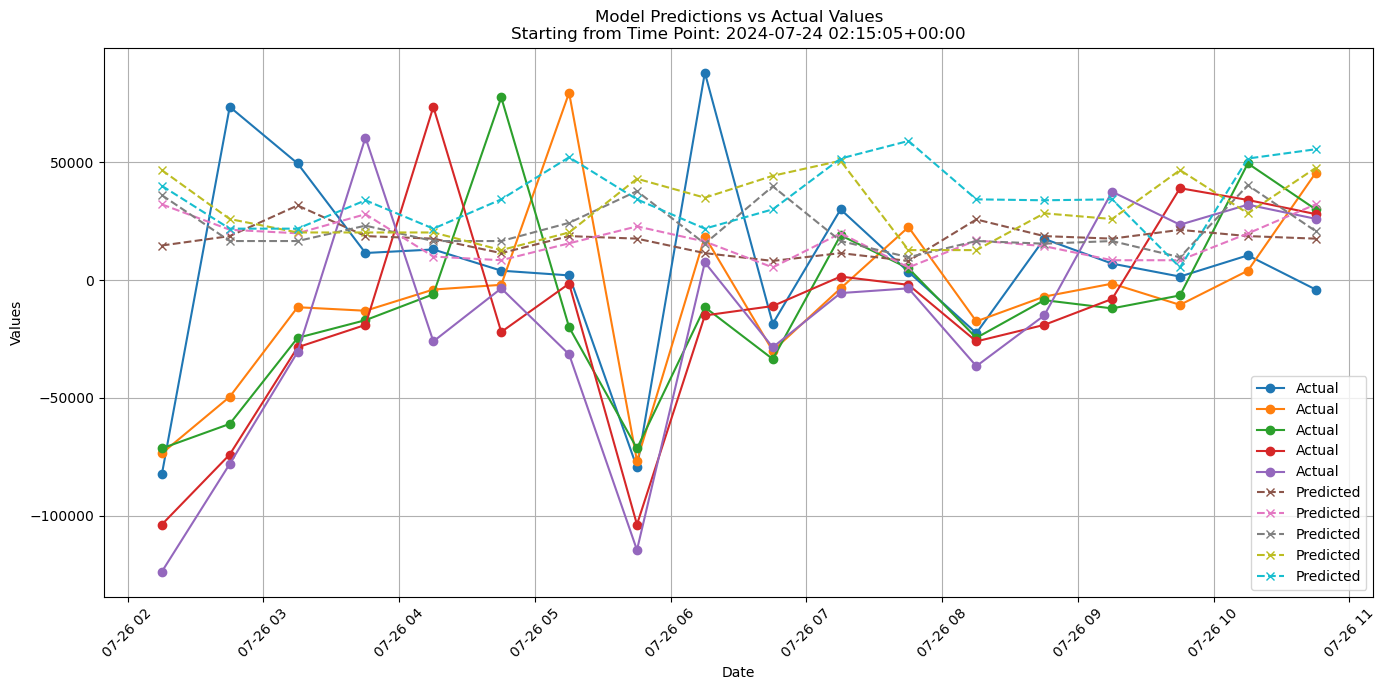

In [41]:
# Extract actual and predicted values for the next 10 time points after the selected time point
actual_values = y_test.iloc[:,:5]
predicted_values = y_pred



# Plotting the predictions vs actual values for the selected time point
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, actual_values, label='Actual', marker='o', linestyle='-')
plt.plot(y_test.index, predicted_values, label='Predicted', marker='x', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Values')
plt.title(f'Model Predictions vs Actual Values\nStarting from Time Point: {timepoints[selected_index]}')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Actual future returns: mid_price_return_current    -82400.0
mid_price_return_1          -73500.0
mid_price_return_2          -71400.0
mid_price_return_3         -103700.0
mid_price_return_4         -123700.0
mid_price_return_5         -102600.0
mid_price_return_6         -123400.0
mid_price_return_7          -74000.0
mid_price_return_8         -112000.0
mid_price_return_9         -127700.0
mid_price_return_10        -127500.0
Name: 2024-07-26 02:15:05+00:00, dtype: float64


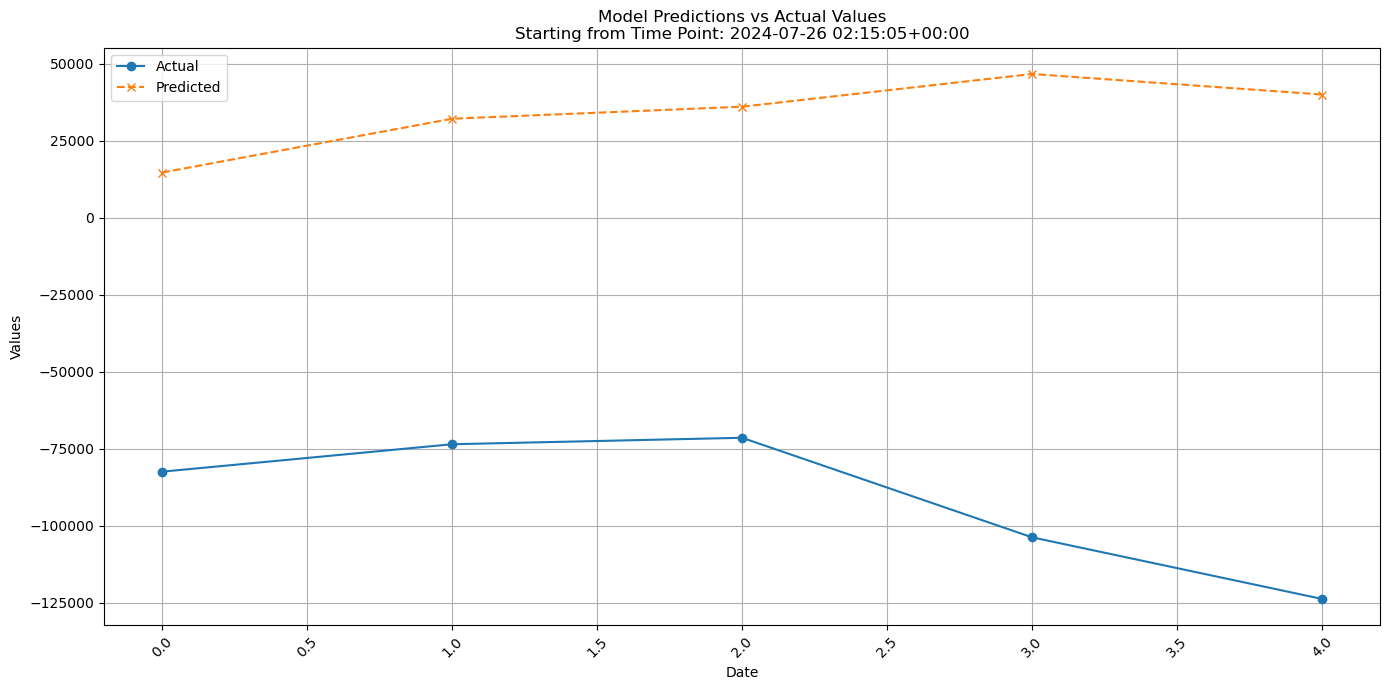

Actual future returns: mid_price_return_current     73500.0
mid_price_return_1          -49500.0
mid_price_return_2          -61000.0
mid_price_return_3          -74000.0
mid_price_return_4          -78000.0
mid_price_return_5          -80000.0
mid_price_return_6            -500.0
mid_price_return_7         -100000.0
mid_price_return_8          -81500.0
mid_price_return_9         -111500.0
mid_price_return_10        -115000.0
Name: 2024-07-26 02:45:05+00:00, dtype: float64


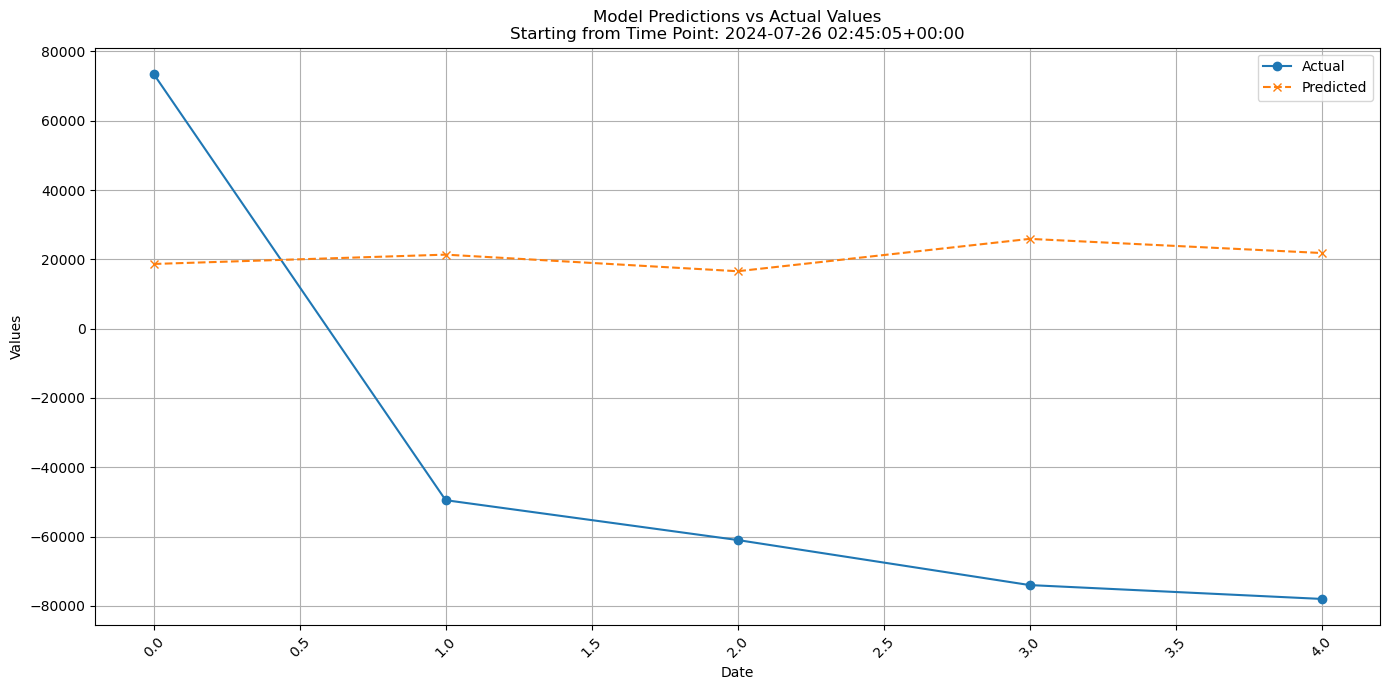

Actual future returns: mid_price_return_current    49500.0
mid_price_return_1         -11500.0
mid_price_return_2         -24500.0
mid_price_return_3         -28500.0
mid_price_return_4         -30500.0
mid_price_return_5          49000.0
mid_price_return_6         -50500.0
mid_price_return_7         -32000.0
mid_price_return_8         -62000.0
mid_price_return_9         -65500.0
mid_price_return_10        -43000.0
Name: 2024-07-26 03:15:05+00:00, dtype: float64


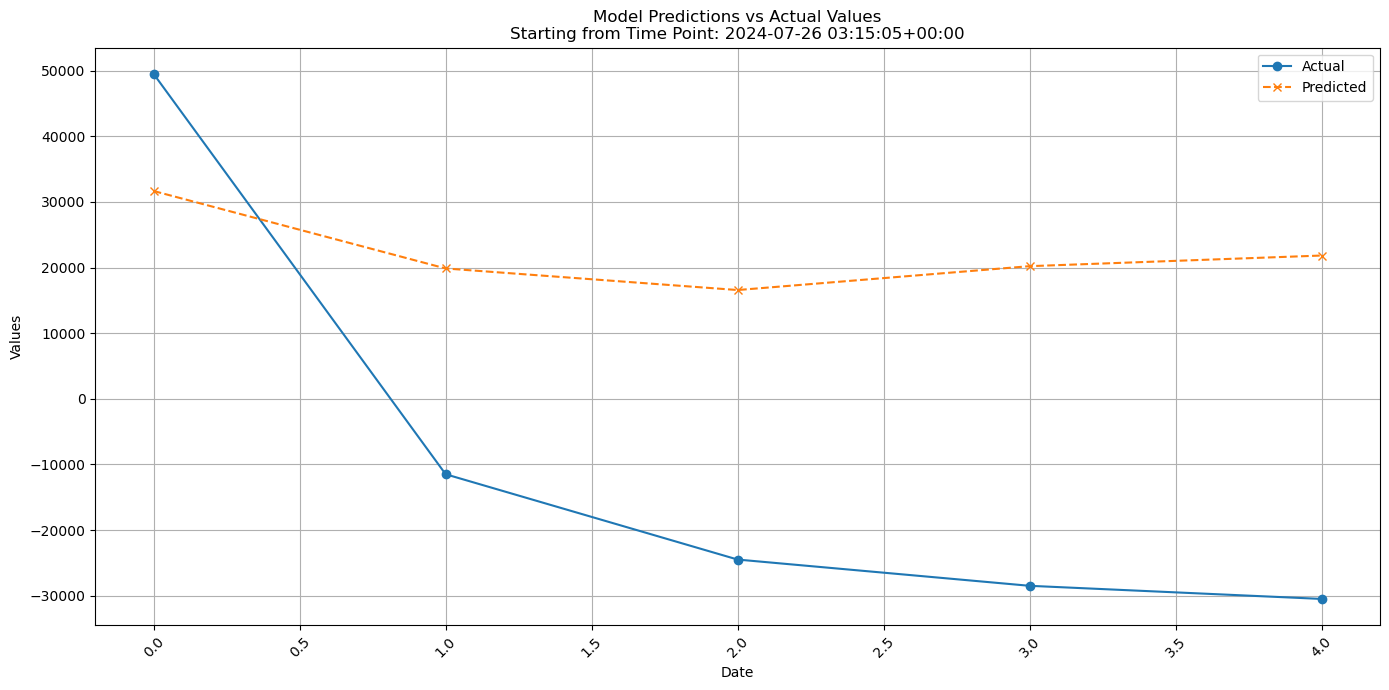

Actual future returns: mid_price_return_current    11500.0
mid_price_return_1         -13000.0
mid_price_return_2         -17000.0
mid_price_return_3         -19000.0
mid_price_return_4          60500.0
mid_price_return_5         -39000.0
mid_price_return_6         -20500.0
mid_price_return_7         -50500.0
mid_price_return_8         -54000.0
mid_price_return_9         -31500.0
mid_price_return_10        -49000.0
Name: 2024-07-26 03:45:05+00:00, dtype: float64


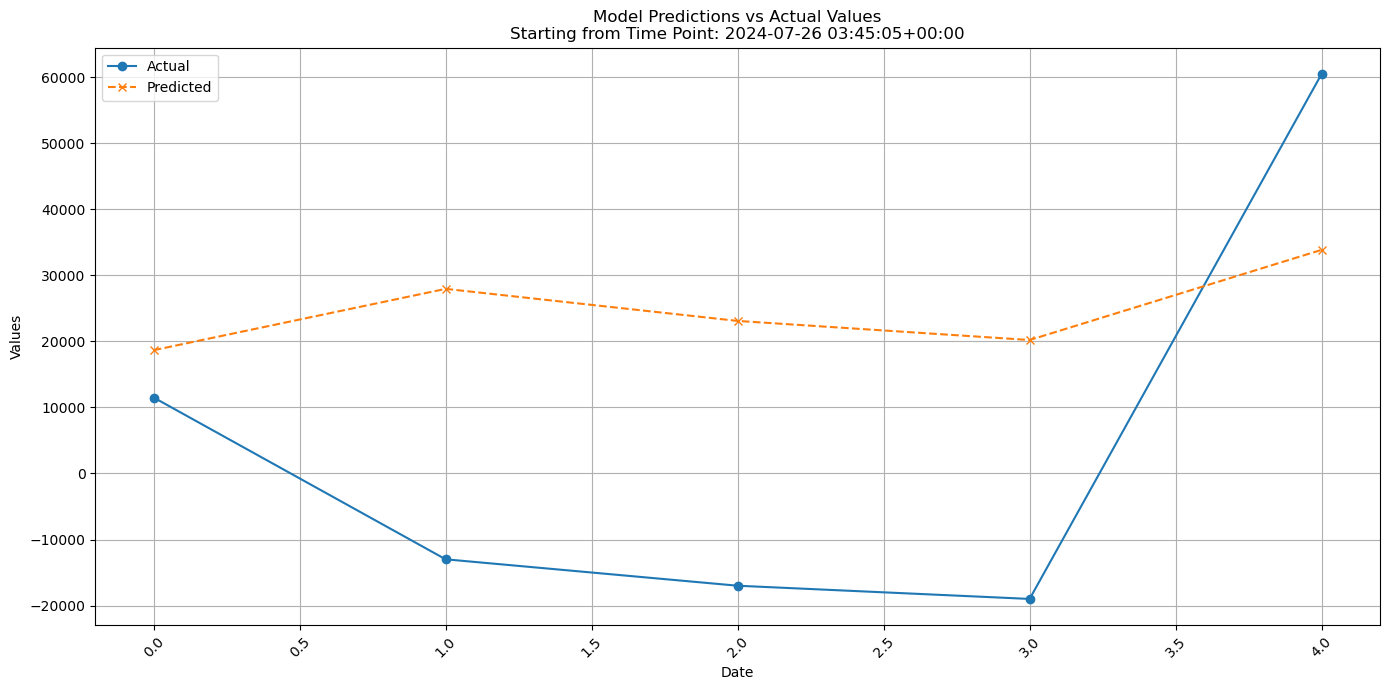

Actual future returns: mid_price_return_current    13000.0
mid_price_return_1          -4000.0
mid_price_return_2          -6000.0
mid_price_return_3          73500.0
mid_price_return_4         -26000.0
mid_price_return_5          -7500.0
mid_price_return_6         -37500.0
mid_price_return_7         -41000.0
mid_price_return_8         -18500.0
mid_price_return_9         -36000.0
mid_price_return_10        -43000.0
Name: 2024-07-26 04:15:05+00:00, dtype: float64


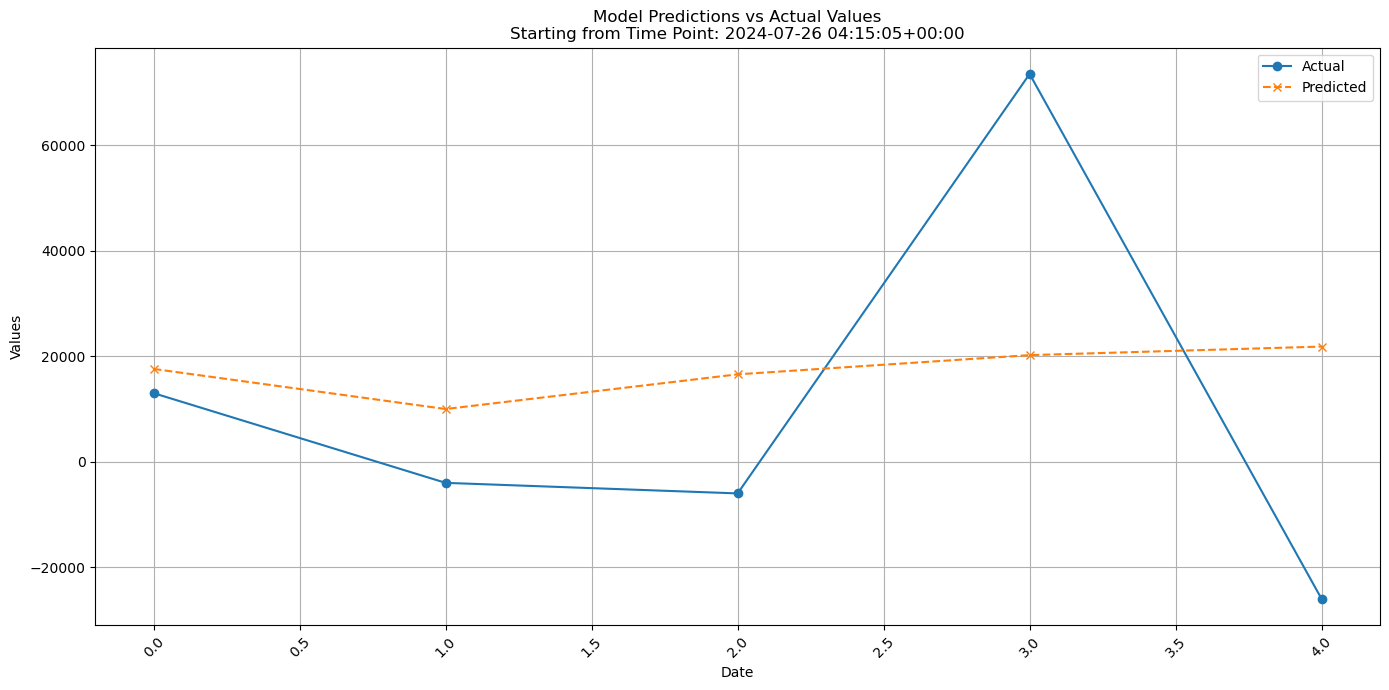

Actual future returns: mid_price_return_current     4000.0
mid_price_return_1          -2000.0
mid_price_return_2          77500.0
mid_price_return_3         -22000.0
mid_price_return_4          -3500.0
mid_price_return_5         -33500.0
mid_price_return_6         -37000.0
mid_price_return_7         -14500.0
mid_price_return_8         -32000.0
mid_price_return_9         -39000.0
mid_price_return_10        -40500.0
Name: 2024-07-26 04:45:06+00:00, dtype: float64


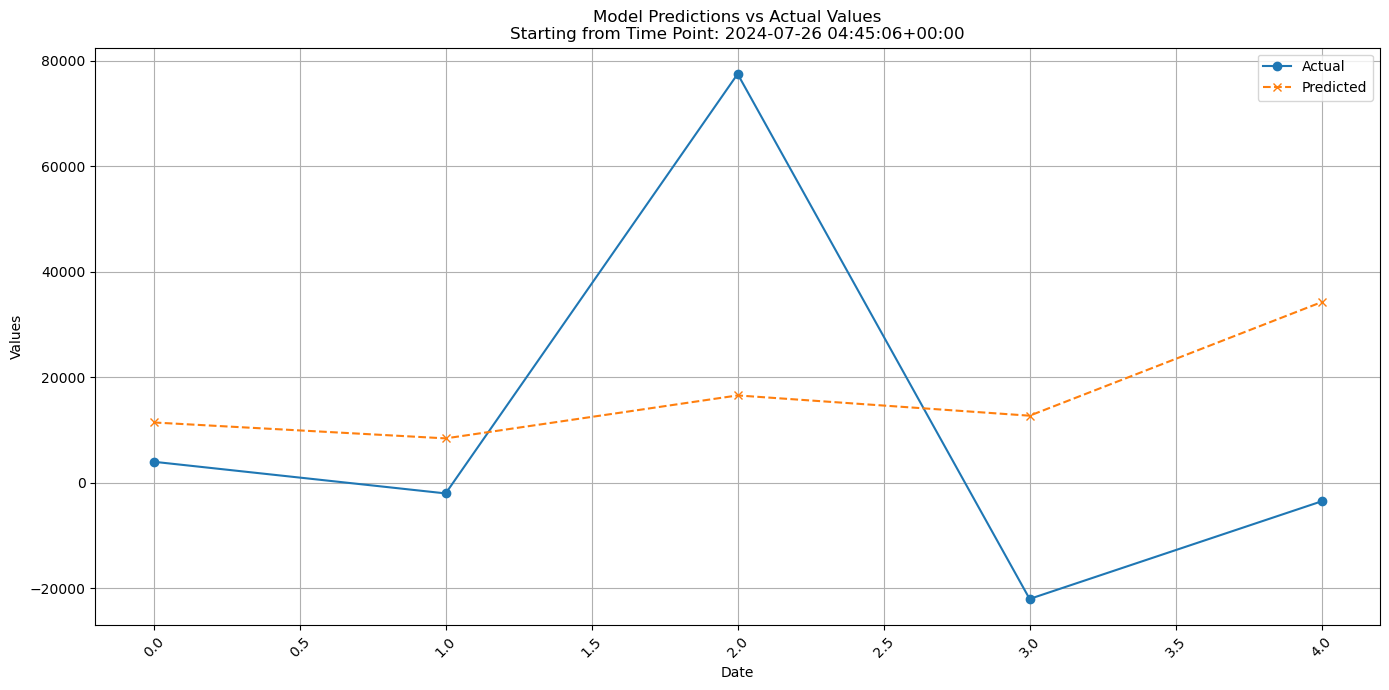

Actual future returns: mid_price_return_current     2000.0
mid_price_return_1          79500.0
mid_price_return_2         -20000.0
mid_price_return_3          -1500.0
mid_price_return_4         -31500.0
mid_price_return_5         -35000.0
mid_price_return_6         -12500.0
mid_price_return_7         -30000.0
mid_price_return_8         -37000.0
mid_price_return_9         -38500.0
mid_price_return_10        -49000.0
Name: 2024-07-26 05:15:05+00:00, dtype: float64


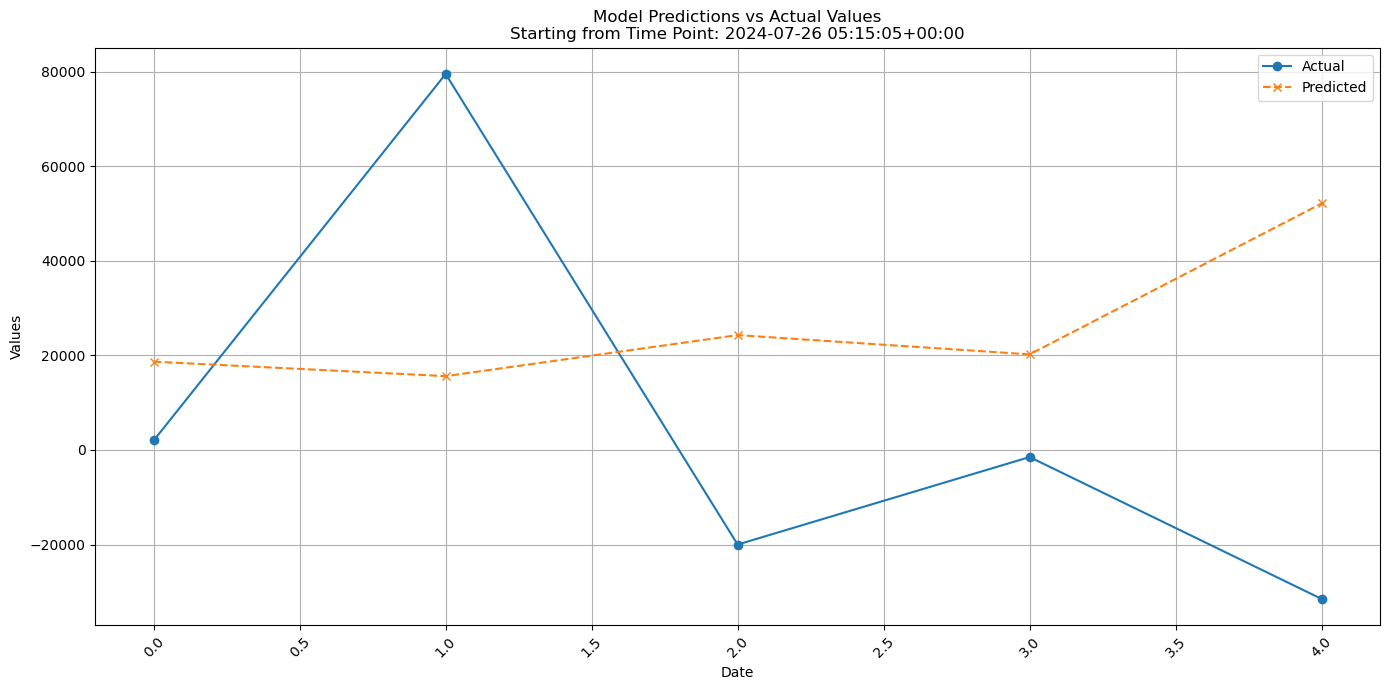

Actual future returns: mid_price_return_current    -79500.0
mid_price_return_1          -76700.0
mid_price_return_2          -71400.0
mid_price_return_3         -103700.0
mid_price_return_4         -114500.0
mid_price_return_5          -92000.0
mid_price_return_6         -109500.0
mid_price_return_7         -101600.0
mid_price_return_8         -112000.0
mid_price_return_9         -127700.0
mid_price_return_10        -124500.0
Name: 2024-07-26 05:45:05+00:00, dtype: float64


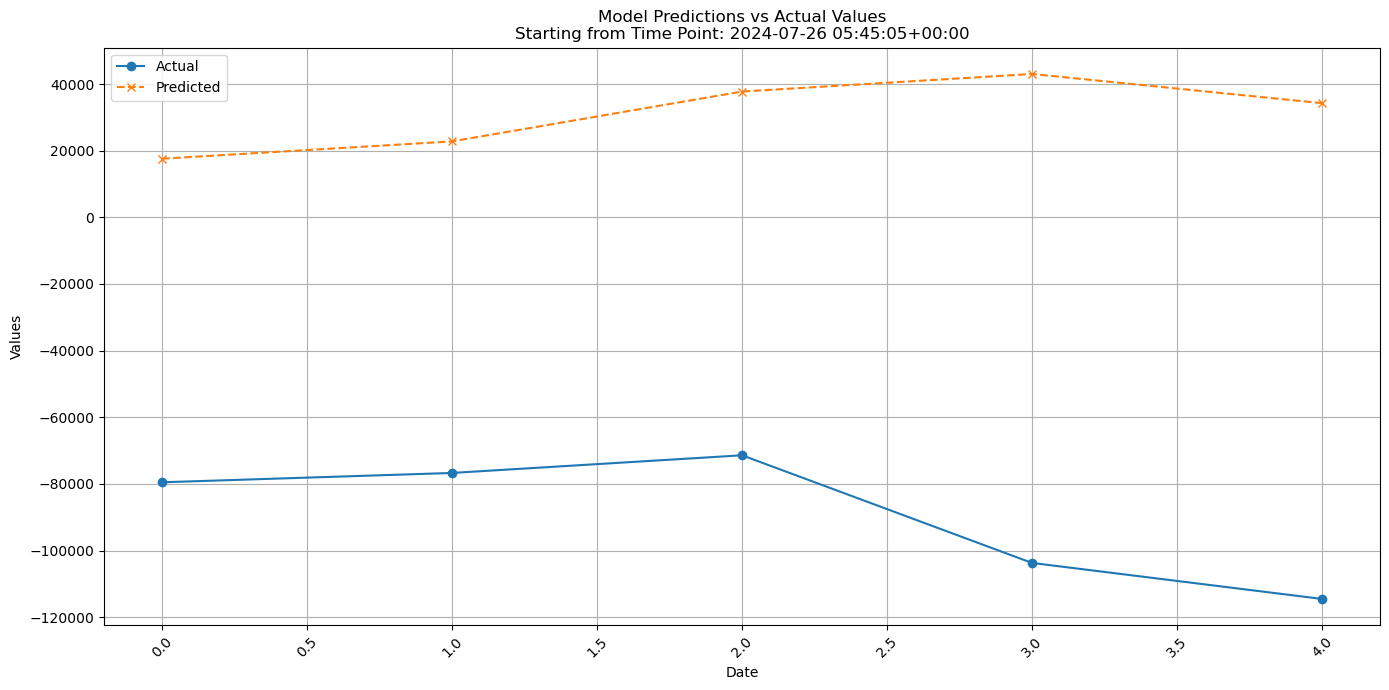

Actual future returns: mid_price_return_current    88000.0
mid_price_return_1          18500.0
mid_price_return_2         -11500.0
mid_price_return_3         -15000.0
mid_price_return_4           7500.0
mid_price_return_5         -10000.0
mid_price_return_6         -17000.0
mid_price_return_7         -18500.0
mid_price_return_8         -29000.0
mid_price_return_9         -25000.0
mid_price_return_10         20500.0
Name: 2024-07-26 06:15:05+00:00, dtype: float64


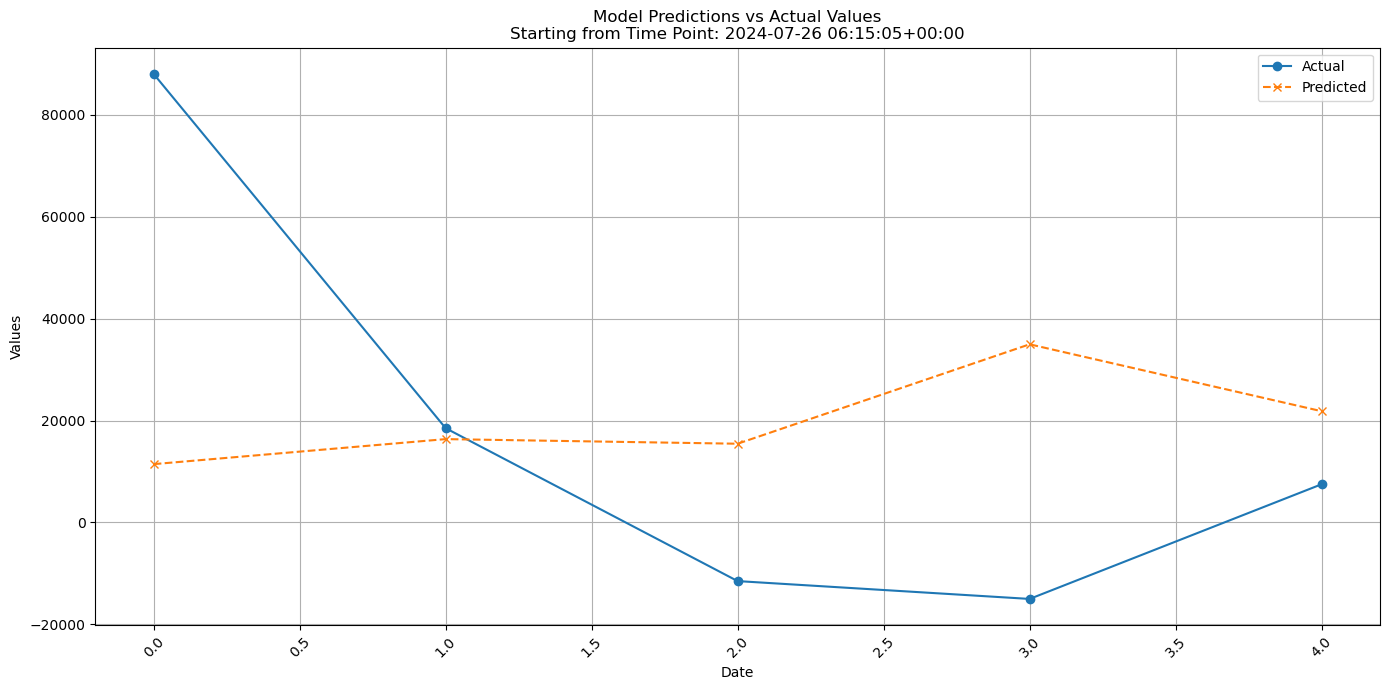

Actual future returns: mid_price_return_current   -18500.0
mid_price_return_1         -30000.0
mid_price_return_2         -33500.0
mid_price_return_3         -11000.0
mid_price_return_4         -28500.0
mid_price_return_5         -35500.0
mid_price_return_6         -37000.0
mid_price_return_7         -47500.0
mid_price_return_8         -43500.0
mid_price_return_9           2000.0
mid_price_return_10        -13500.0
Name: 2024-07-26 06:45:06+00:00, dtype: float64


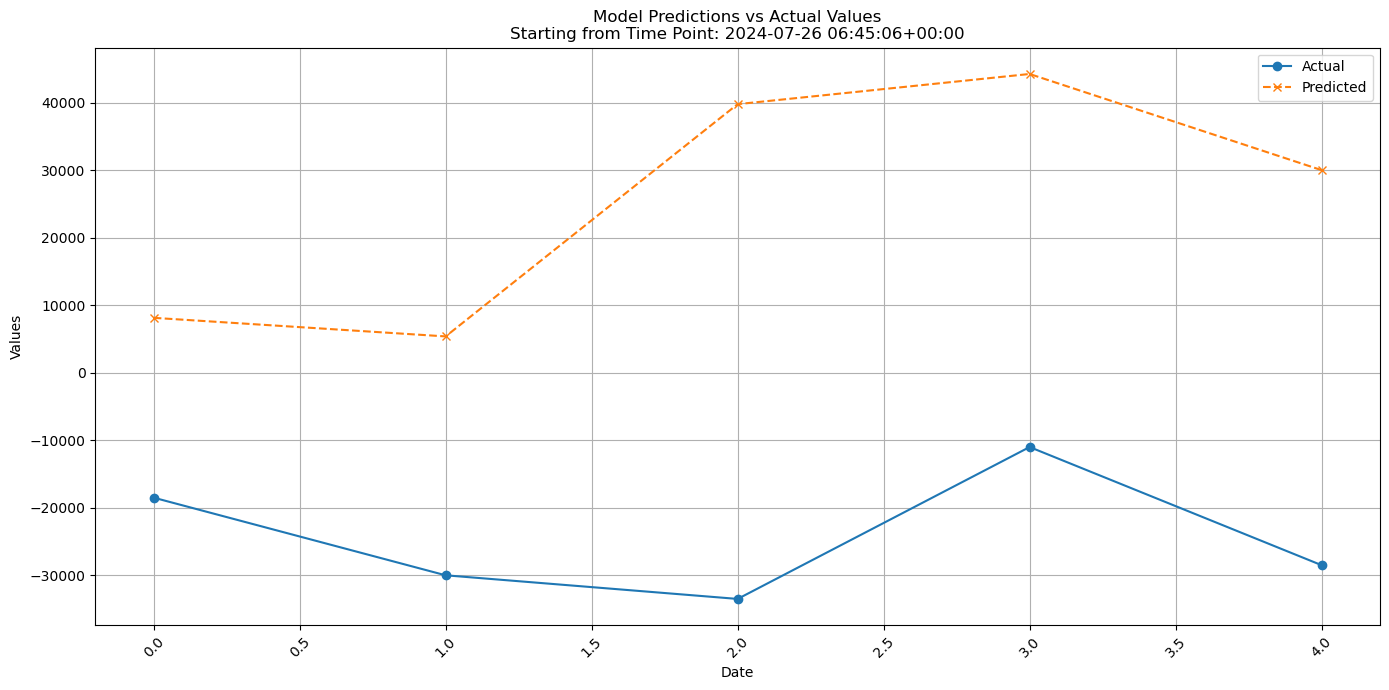

Actual future returns: mid_price_return_current    30000.0
mid_price_return_1          -3500.0
mid_price_return_2          19000.0
mid_price_return_3           1500.0
mid_price_return_4          -5500.0
mid_price_return_5          -7000.0
mid_price_return_6         -17500.0
mid_price_return_7         -13500.0
mid_price_return_8          32000.0
mid_price_return_9          16500.0
mid_price_return_10         14500.0
Name: 2024-07-26 07:15:05+00:00, dtype: float64


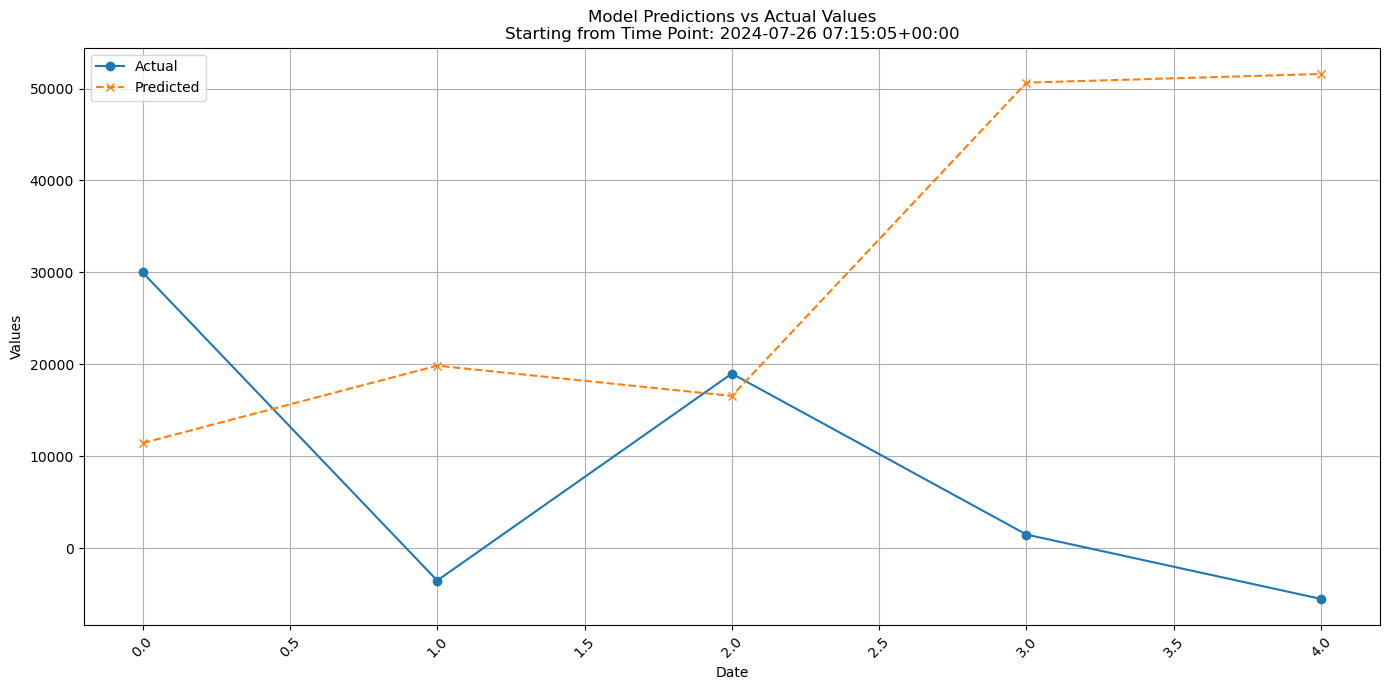

Actual future returns: mid_price_return_current     3500.0
mid_price_return_1          22500.0
mid_price_return_2           5000.0
mid_price_return_3          -2000.0
mid_price_return_4          -3500.0
mid_price_return_5         -14000.0
mid_price_return_6         -10000.0
mid_price_return_7          35500.0
mid_price_return_8          20000.0
mid_price_return_9          18000.0
mid_price_return_10         16000.0
Name: 2024-07-26 07:45:05+00:00, dtype: float64


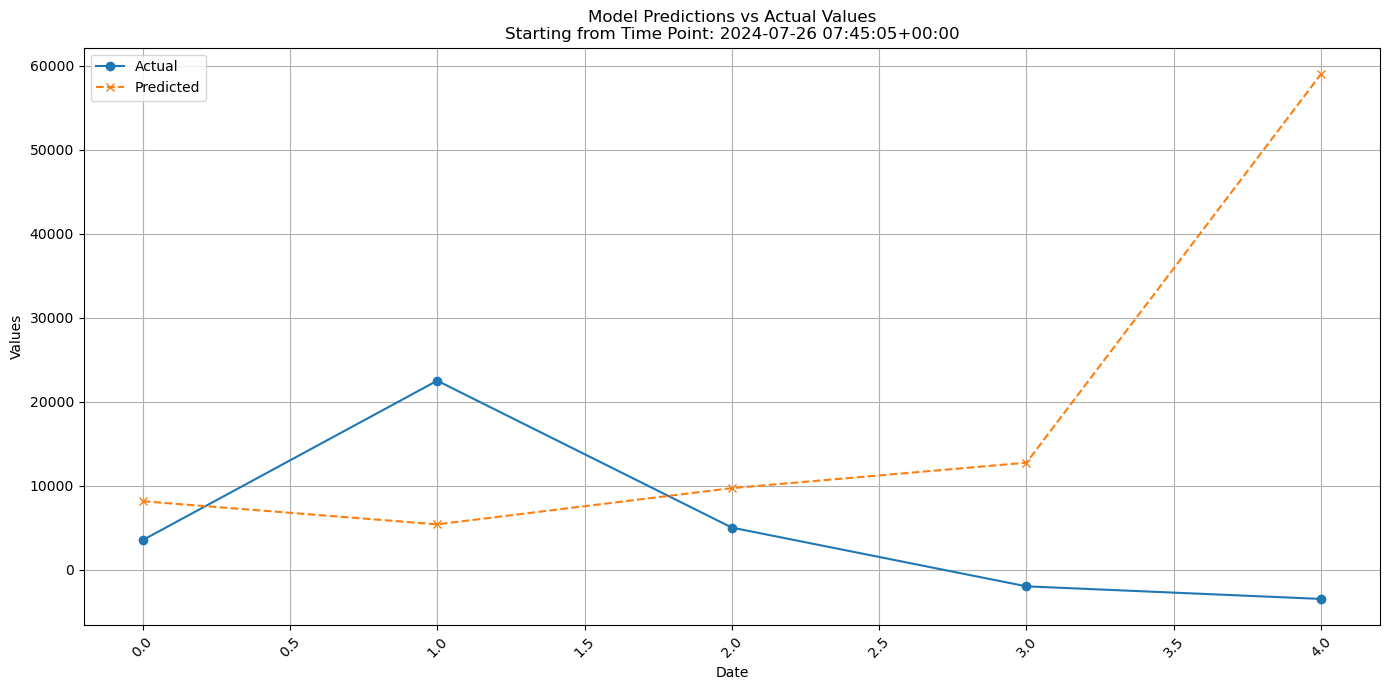

Actual future returns: mid_price_return_current   -22500.0
mid_price_return_1         -17500.0
mid_price_return_2         -24500.0
mid_price_return_3         -26000.0
mid_price_return_4         -36500.0
mid_price_return_5         -32500.0
mid_price_return_6          13000.0
mid_price_return_7          -2500.0
mid_price_return_8          -4500.0
mid_price_return_9          -6500.0
mid_price_return_10        -56500.0
Name: 2024-07-26 08:15:05+00:00, dtype: float64


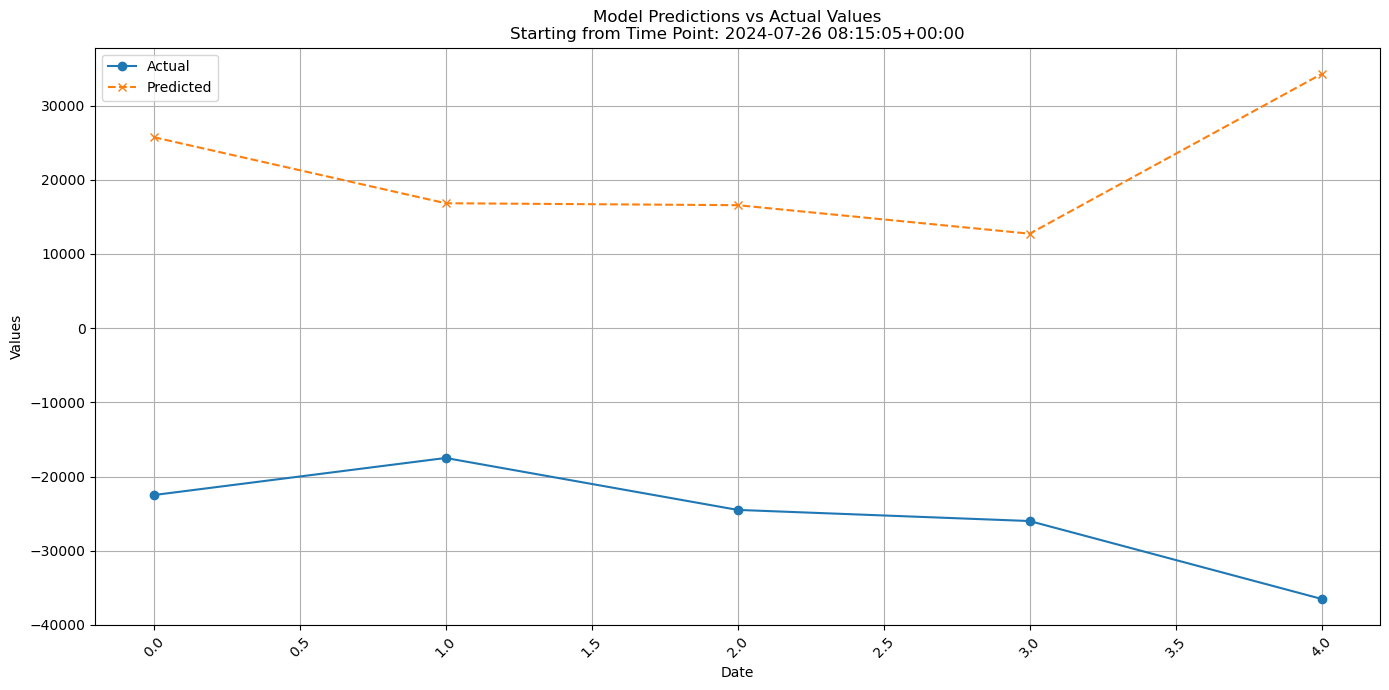

Actual future returns: mid_price_return_current    17500.0
mid_price_return_1          -7000.0
mid_price_return_2          -8500.0
mid_price_return_3         -19000.0
mid_price_return_4         -15000.0
mid_price_return_5          30500.0
mid_price_return_6          15000.0
mid_price_return_7          13000.0
mid_price_return_8          11000.0
mid_price_return_9         -39000.0
mid_price_return_10         11500.0
Name: 2024-07-26 08:45:05+00:00, dtype: float64


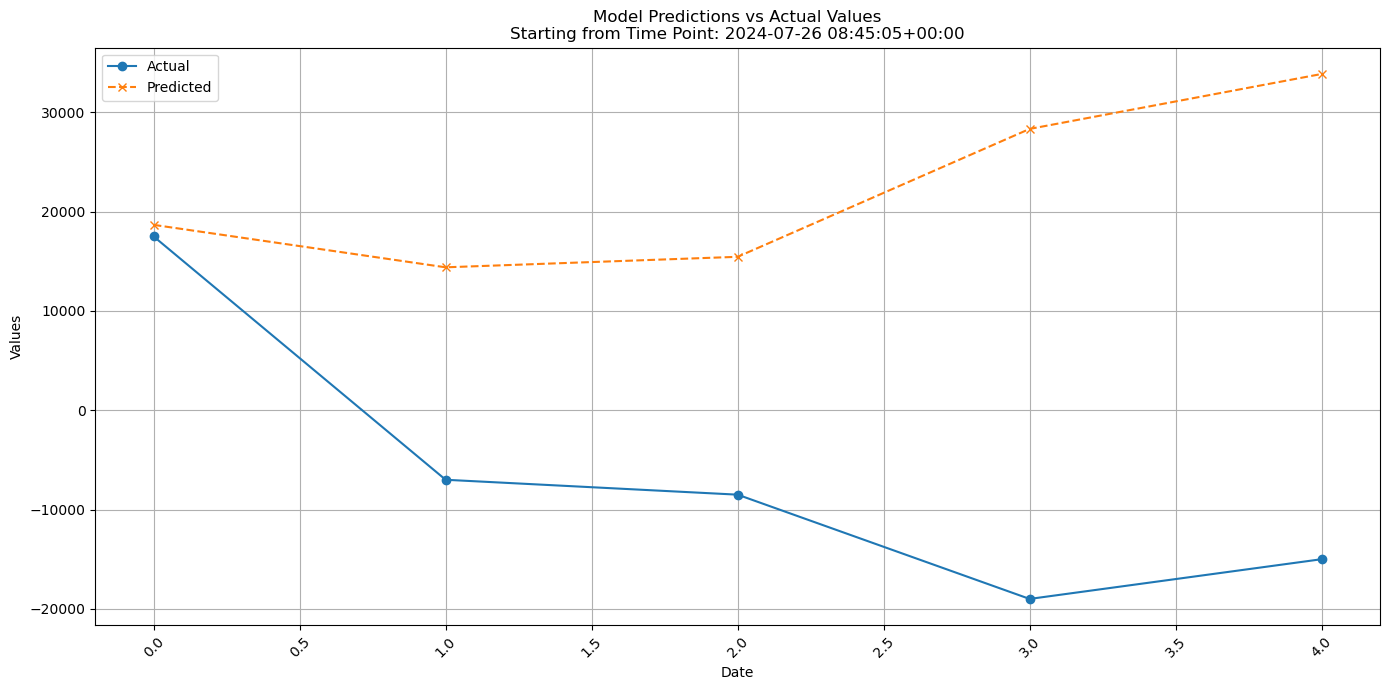

Actual future returns: mid_price_return_current     7000.0
mid_price_return_1          -1500.0
mid_price_return_2         -12000.0
mid_price_return_3          -8000.0
mid_price_return_4          37500.0
mid_price_return_5          22000.0
mid_price_return_6          20000.0
mid_price_return_7          18000.0
mid_price_return_8         -32000.0
mid_price_return_9          18500.0
mid_price_return_10          2000.0
Name: 2024-07-26 09:15:05+00:00, dtype: float64


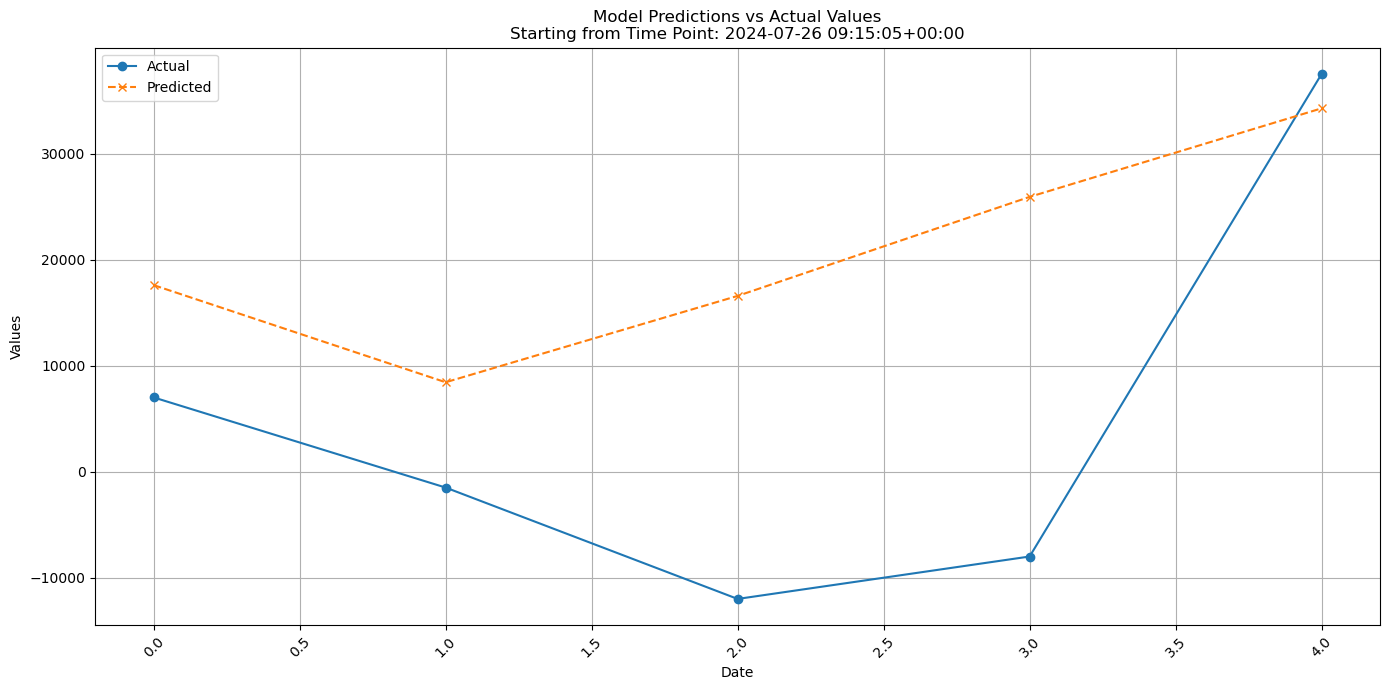

Actual future returns: mid_price_return_current     1500.0
mid_price_return_1         -10500.0
mid_price_return_2          -6500.0
mid_price_return_3          39000.0
mid_price_return_4          23500.0
mid_price_return_5          21500.0
mid_price_return_6          19500.0
mid_price_return_7         -30500.0
mid_price_return_8          20000.0
mid_price_return_9           3500.0
mid_price_return_10         31000.0
Name: 2024-07-26 09:45:05+00:00, dtype: float64


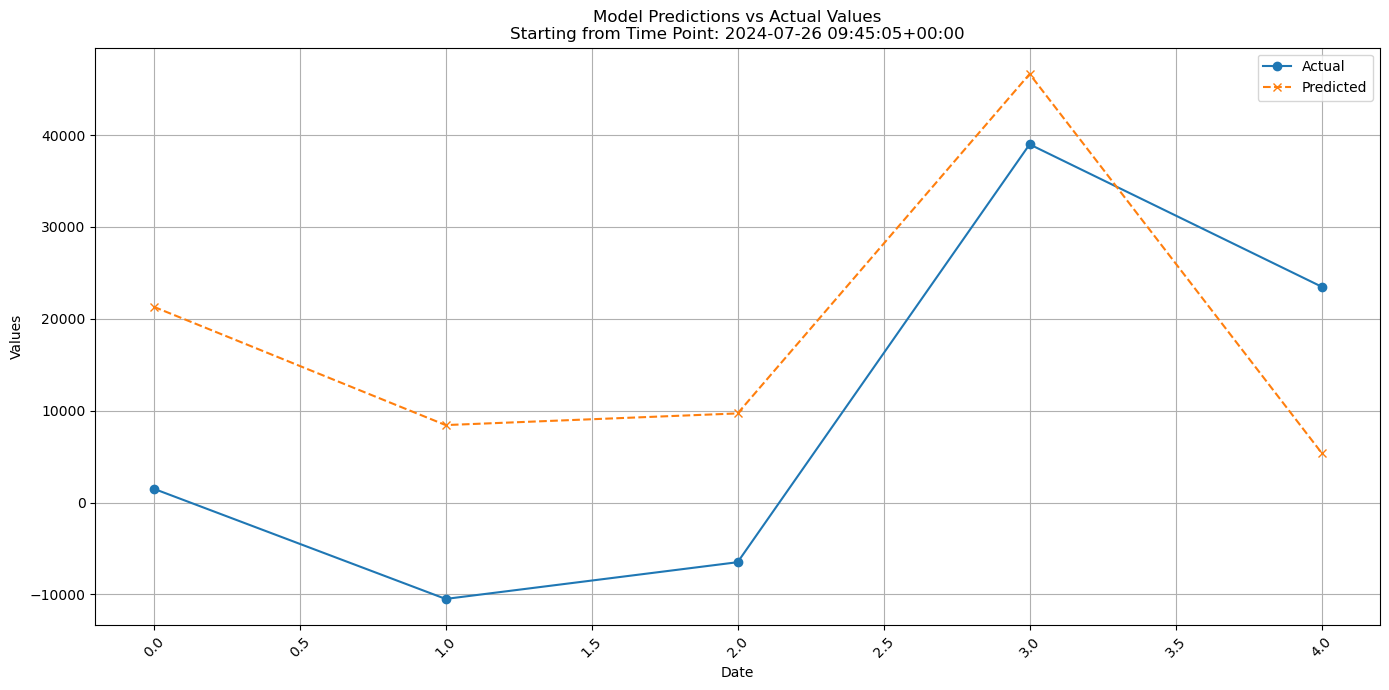

Actual future returns: mid_price_return_current    10500.0
mid_price_return_1           4000.0
mid_price_return_2          49500.0
mid_price_return_3          34000.0
mid_price_return_4          32000.0
mid_price_return_5          30000.0
mid_price_return_6         -20000.0
mid_price_return_7          30500.0
mid_price_return_8          14000.0
mid_price_return_9          41500.0
mid_price_return_10         94000.0
Name: 2024-07-26 10:15:05+00:00, dtype: float64


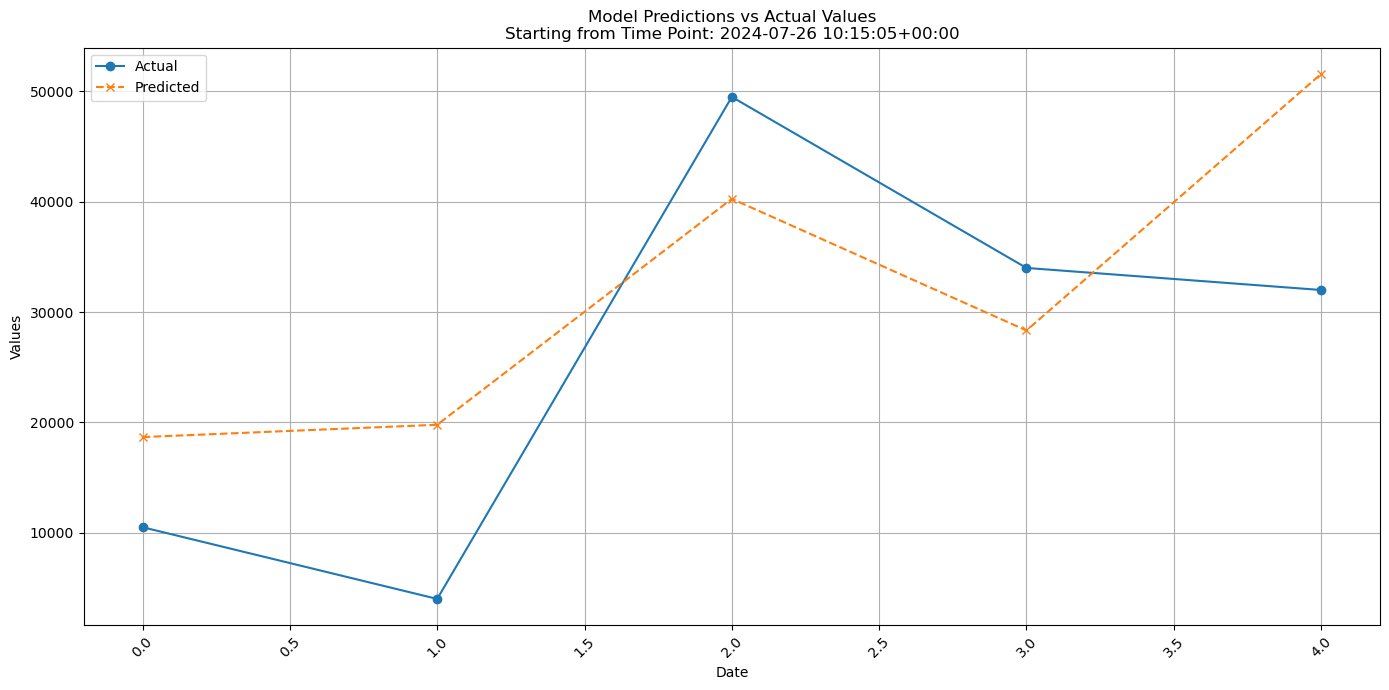

Actual future returns: mid_price_return_current    -4000.0
mid_price_return_1          45500.0
mid_price_return_2          30000.0
mid_price_return_3          28000.0
mid_price_return_4          26000.0
mid_price_return_5         -24000.0
mid_price_return_6          26500.0
mid_price_return_7          10000.0
mid_price_return_8          37500.0
mid_price_return_9          90000.0
mid_price_return_10         39500.0
Name: 2024-07-26 10:45:05+00:00, dtype: float64


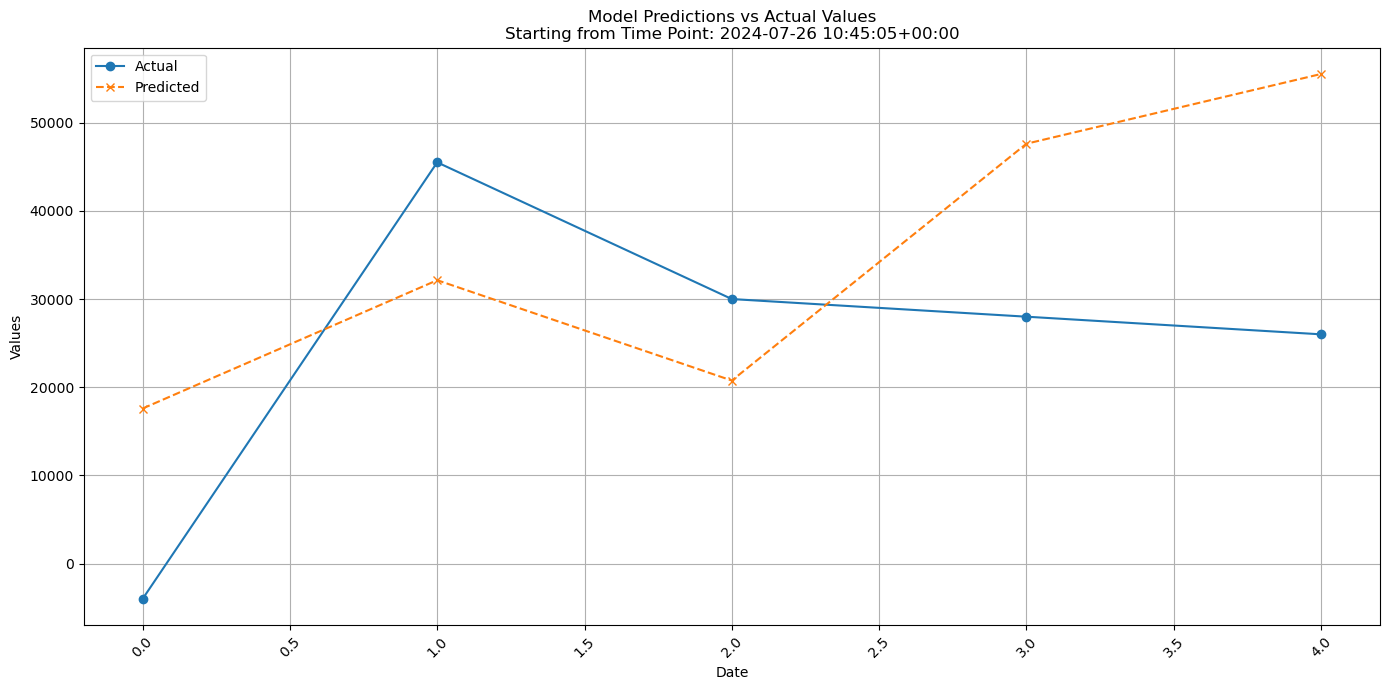

In [23]:
for i in range(len(y_test)):
    future_returns_actual = y_test.iloc[i]
    future_returns_predicted = y_pred[i]
    timepoints = y_test.index
    current_timepoints = timepoints[i]
   
    
    
    # print("Future time points:", future_timepoints)
    print("Actual future returns:", future_returns_actual)
     # Plotting the predictions vs actual values for the selected time point
    plt.figure(figsize=(14, 7))
    plt.plot(range(5), future_returns_actual[:5], label='Actual', marker='o', linestyle='-')
    plt.plot(range(5), future_returns_predicted, label='Predicted', marker='x', linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.title(f'Model Predictions vs Actual Values\nStarting from Time Point: {timepoints[i]}')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    

### Train simple LSTM model:

In [24]:
import torch
import torch.nn as nn
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out



In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Example shapes (replace these with your actual data shapes)
X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)
y_train_scaled = torch.tensor(y_train_scaled, dtype=torch.float32)
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1)
y_test_scaled = torch.tensor(y_test_scaled, dtype=torch.float32)
# Check the shapes
print(X_train_scaled.shape)  # Shape: (num_samples, seq_length, num_features)
print(y_train_scaled.shape)  # Shape: (num_samples, n_future_timesteps)


torch.Size([81, 1, 14])
torch.Size([81, 5])


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected output layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Assuming X_train_scaled and y_train_scaled are already available as PyTorch tensors
batch_size = 4

# Create a TensorDataset
train_dataset = TensorDataset(X_train_scaled, y_train_scaled)
test_dataset = TensorDataset(X_test_scaled, y_test_scaled)
# Create a DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
# Define the model
input_size = X_train_scaled.shape[2]   # Number of features
hidden_size = 50                       # Number of LSTM units
num_layers = 2                         # Number of LSTM layers
output_size = y_train_scaled.shape[1]  # Number of future timesteps to predict

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with DataLoader
num_epochs = 100
for epoch in range(num_epochs):
    for i, (X_batch, y_batch) in enumerate(train_loader):
        model.train()
        
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:  # Print every 10th batch
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


Epoch [1/100], Step [10/21], Loss: 1.0387
Epoch [1/100], Step [20/21], Loss: 0.9405
Epoch [2/100], Step [10/21], Loss: 0.8074
Epoch [2/100], Step [20/21], Loss: 0.6294
Epoch [3/100], Step [10/21], Loss: 1.2877
Epoch [3/100], Step [20/21], Loss: 0.5185
Epoch [4/100], Step [10/21], Loss: 1.2252
Epoch [4/100], Step [20/21], Loss: 1.5623
Epoch [5/100], Step [10/21], Loss: 0.3228
Epoch [5/100], Step [20/21], Loss: 0.6165
Epoch [6/100], Step [10/21], Loss: 0.2647
Epoch [6/100], Step [20/21], Loss: 0.3286
Epoch [7/100], Step [10/21], Loss: 0.7610
Epoch [7/100], Step [20/21], Loss: 0.4963
Epoch [8/100], Step [10/21], Loss: 0.2652
Epoch [8/100], Step [20/21], Loss: 1.9432
Epoch [9/100], Step [10/21], Loss: 0.8546
Epoch [9/100], Step [20/21], Loss: 0.2583
Epoch [10/100], Step [10/21], Loss: 0.9784
Epoch [10/100], Step [20/21], Loss: 1.2668
Epoch [11/100], Step [10/21], Loss: 1.1855
Epoch [11/100], Step [20/21], Loss: 0.9119
Epoch [12/100], Step [10/21], Loss: 1.0990
Epoch [12/100], Step [20/21],

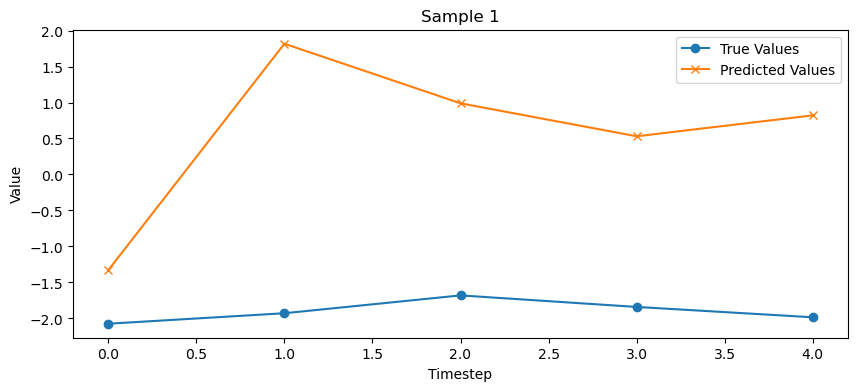

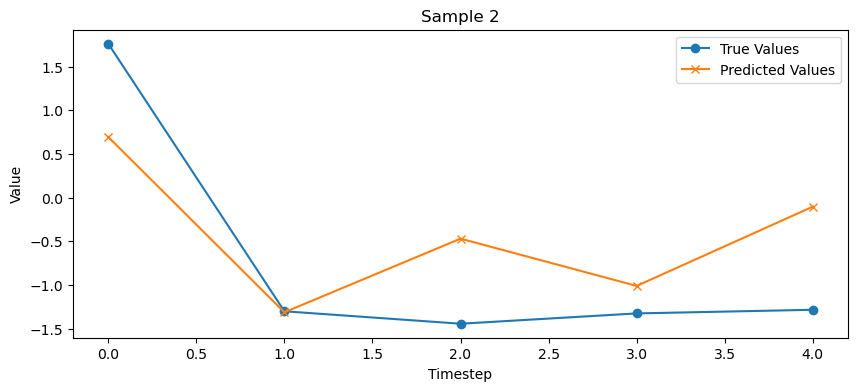

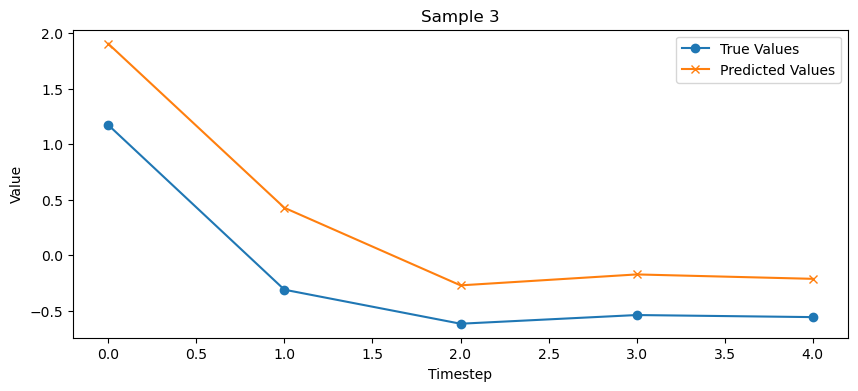

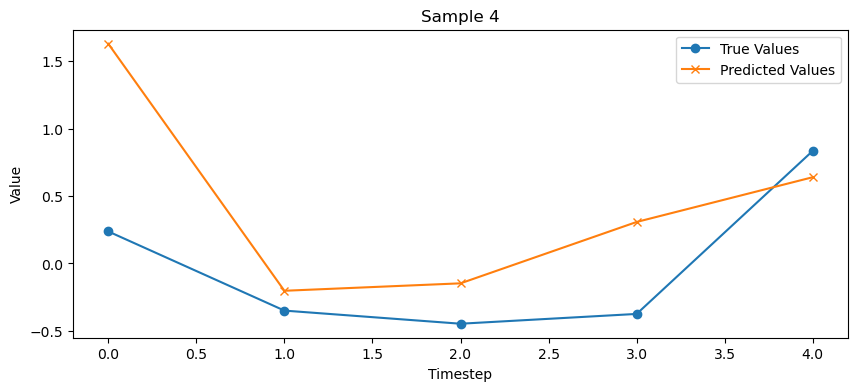

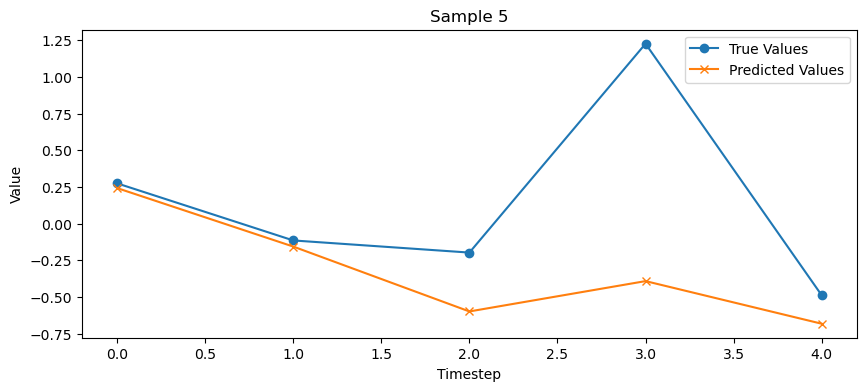

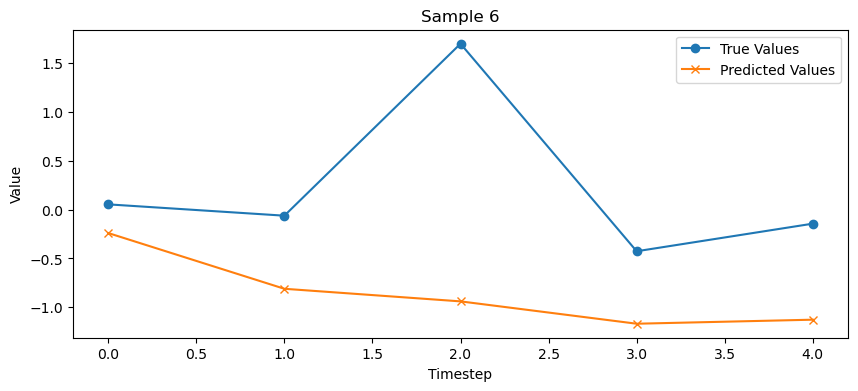

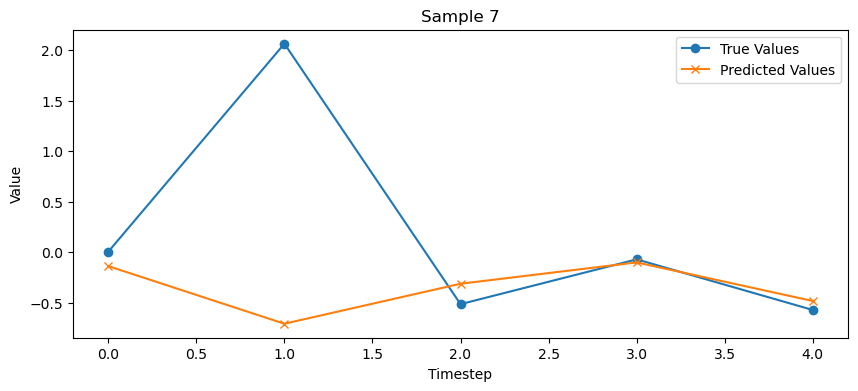

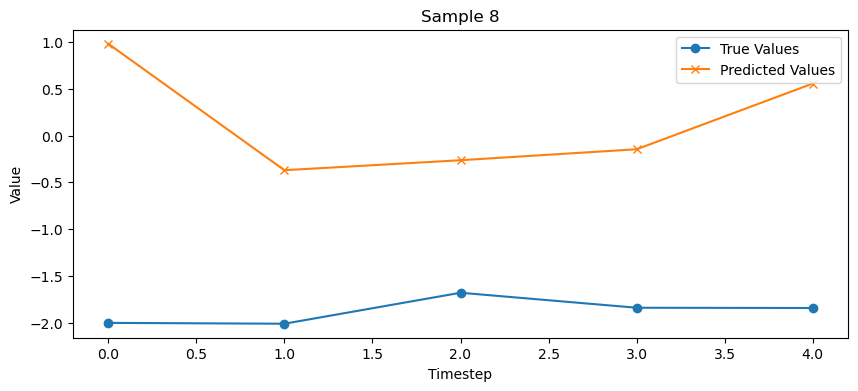

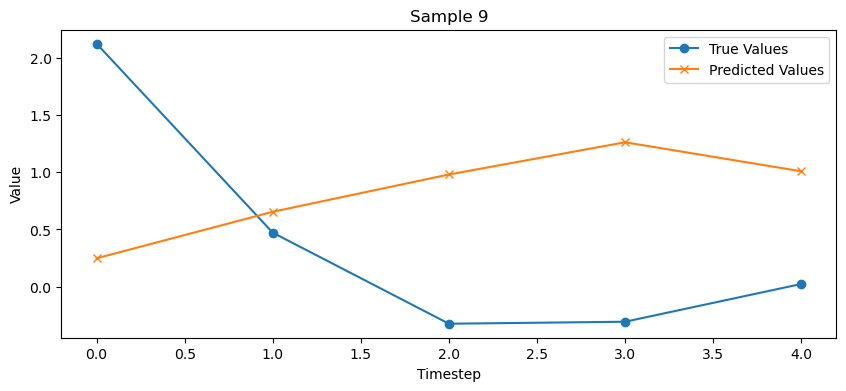

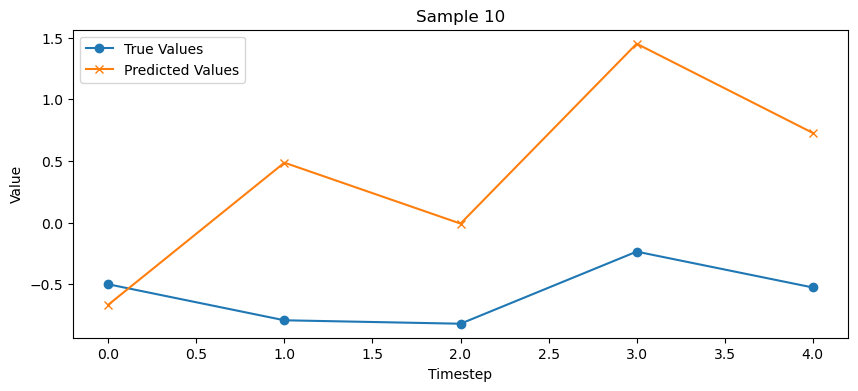

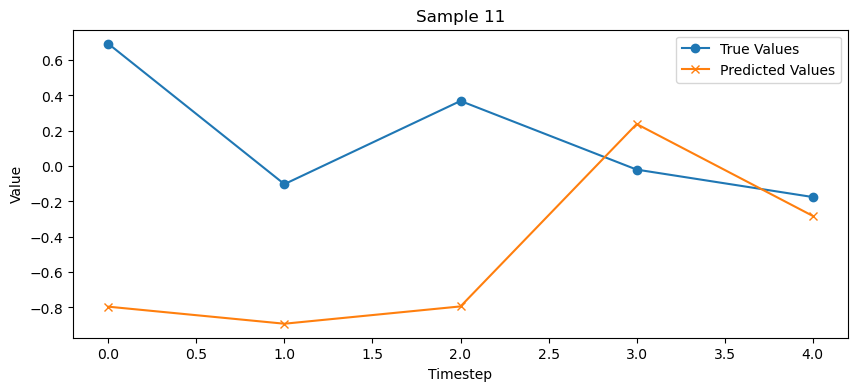

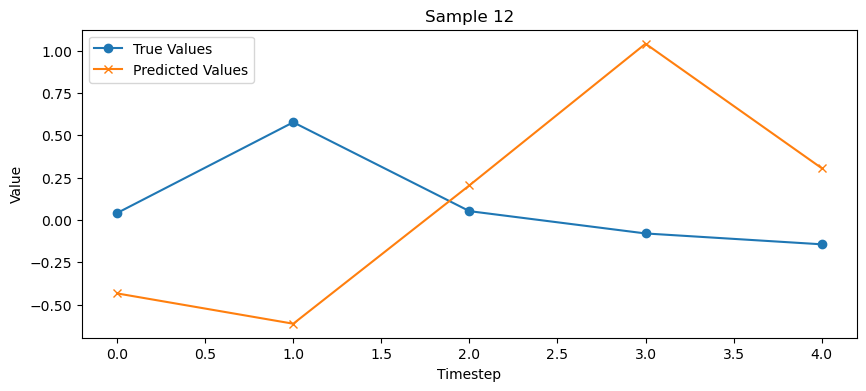

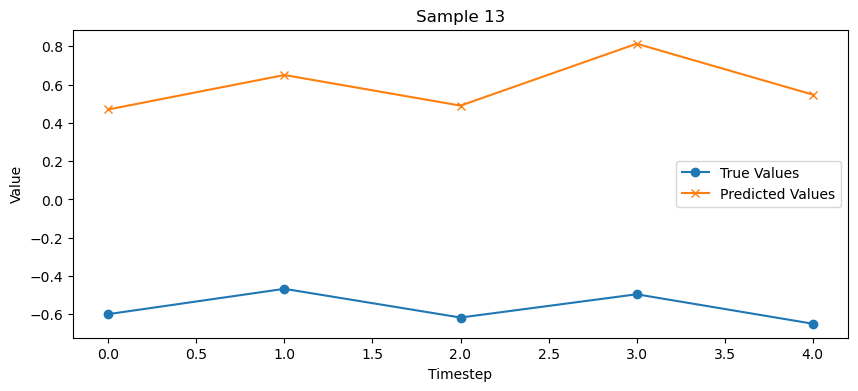

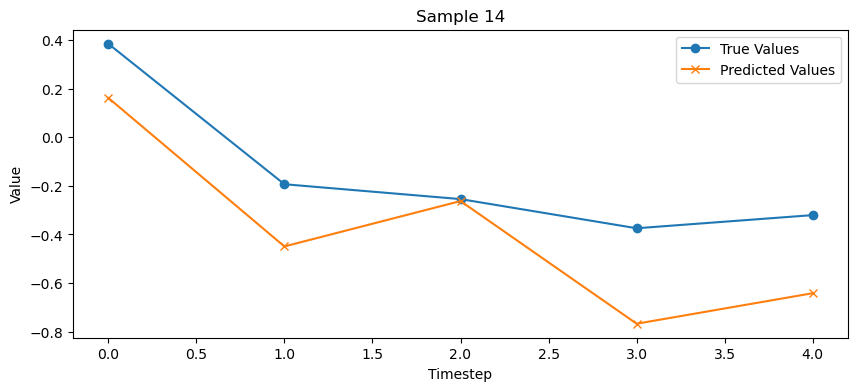

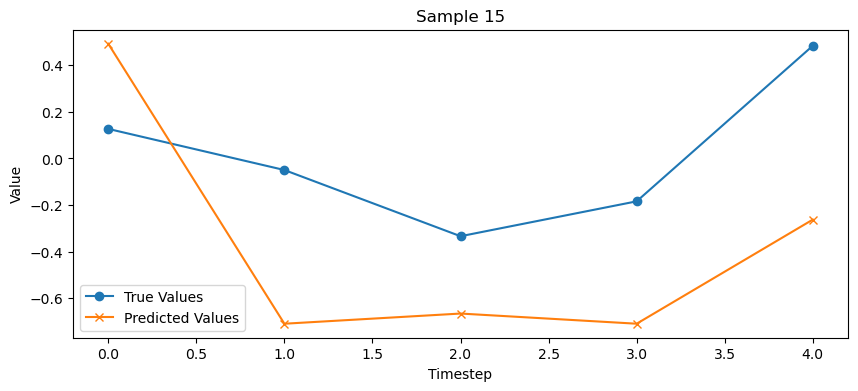

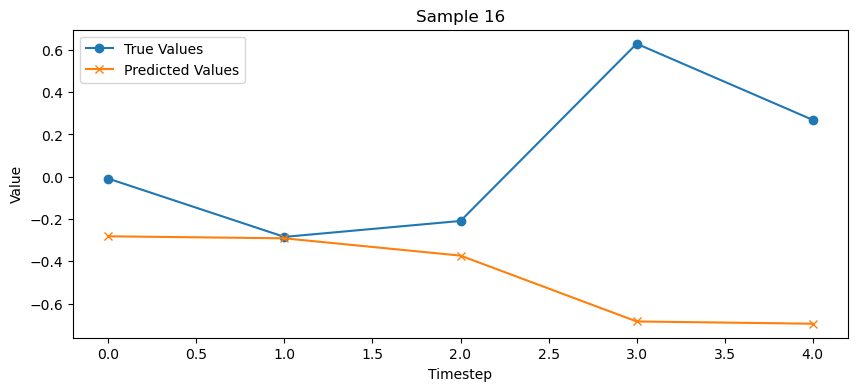

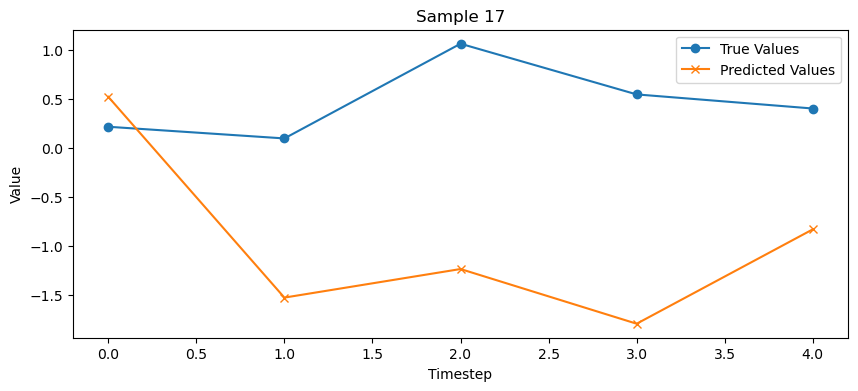

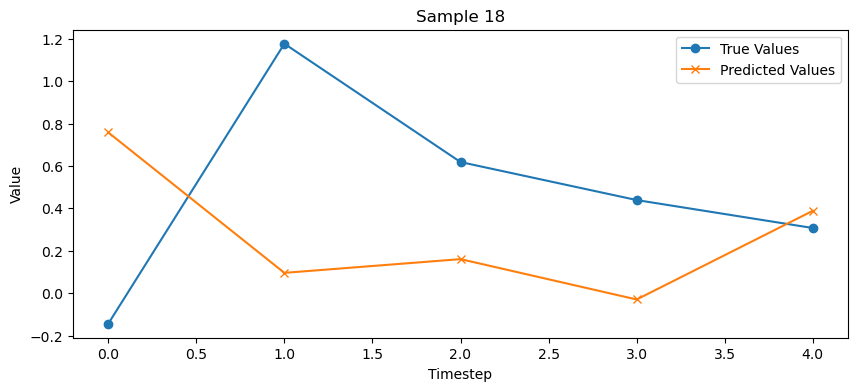

In [27]:
import torch
import matplotlib.pyplot as plt

# Assuming the model has already been trained and test_loader is prepared
model.eval()

all_predictions = []
all_true_values = []

# Disable gradient calculation for inference
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        all_predictions.append(y_pred)
        all_true_values.append(y_batch)

# Concatenate all batches to get the full predictions and true values
all_predictions = torch.cat(all_predictions).cpu().numpy()
all_true_values = torch.cat(all_true_values).cpu().numpy()

# Plot predictions vs. true values for each sample
num_samples = all_predictions.shape[0]
n_future_timesteps = all_predictions.shape[1]

for i in range(num_samples):
    plt.figure(figsize=(10, 4))
    plt.plot(range(n_future_timesteps), all_true_values[i], label='True Values', marker='o')
    plt.plot(range(n_future_timesteps), all_predictions[i], label='Predicted Values', marker='x')
    plt.title(f'Sample {i+1}')
    plt.xlabel('Timestep')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
